In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

import pandas as pd

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

In [2]:
from R125_bmimPF6_PR import configuration
data = pd.read_csv('R125IL.csv')

solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [3]:
m = ConcreteModel()

m.fs = FlowsheetBlock(default={"dynamic": False})

m.fs.properties = GenericParameterBlock(default=configuration)

m.fs.F101 = Flash(default={"property_package": m.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m.fs.F101.inlet.flow_mol.fix(1)
m.fs.F101.inlet.temperature.fix(323.15)
m.fs.F101.inlet.pressure.fix(399800)
m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(0.5)

m.fs.properties.PR_kappa['bmimPF6', 'R125'].fix(0.08425780511776507)
m.fs.properties.PR_kappa['R125', 'bmimPF6'].fix(0.02825770121014014)

# Initialize the flash unit
m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)

# Fix the state variables on the state block
# m.fs.F101.inlet.pressure.unfix()
m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].unfix()

R125_x = np.zeros((len(data)))
P = np.zeros((len(data)))

m.fs.liq = Param(mutable=True,default=0.040)
m.fs.liquid = Constraint(expr=m.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"] == m.fs.liq)

for i in range(len(data)):
    m.fs.liq = data["x_bmimPF6"].iloc[i]
    m.fs.F101.inlet.temperature.fix(float(data["temperature"].iloc[i]))
    m.fs.F101.inlet.pressure.fix(float(data["pressure"].iloc[i]))
    m.fs.F101.inlet.mole_frac_comp[0,'R125'].fix(float(data["x_R125"].iloc[i])+0.08)
    m.fs.F101.inlet.mole_frac_comp[0,'bmimPF6'].fix(float(1-(data["x_R125"].iloc[i]+0.08)))
    m.fs.F101.vap_outlet.temperature.fix(float(data["temperature"].iloc[i]))
    
    DOF_final = degrees_of_freedom(m)
    print("The final DOF is {0}".format(DOF_final))
    m.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    status = solver.solve(m, tee = False)

#     m.fs.F101.report()
    if (status.solver.status == SolverStatus.ok) and (status.solver.termination_condition == TerminationCondition.optimal):

        R125_x[i] = value(m.fs.F101.liq_outlet.mole_frac_comp[0,'R125']) 
        P[i] = value(m.fs.F101.vap_outlet.pressure[0])

    else:
        print('Infeasible.')

2021-08-16 12:19:14 [INFO] idaes.generic_models.properties.core.generic.generic_property: DEPRECATED - definiton of generic property packages is moving to using static classes instead of modules. Please refer to the IDAES documentation.
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
    model.name="unknown";
      - termination condition: infeasible
      - message from solver: Ipopt 3.12.13\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
Infeasible.
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final DOF is 0
The final

In [4]:
print(P)
print(data["pressure"])
print(R125_x)
print(data["x_R125"])

[  29687.94900029   77573.20436638  170207.30605958  281745.52949531
  407423.62004103  543290.29751066  697647.87682333  857056.30286079
       0.            9802.66504538   75133.27880771  163180.72241739
  260063.04859444  360769.4905013   463171.06385717  579931.68657127
  826312.86759234 1104138.70158548   69750.55923438  150689.38696827
  227078.16895459  308529.31800114  391573.81105057  473629.23292138
  657252.06942556  848467.04984767   56043.28735617  128752.5442937
  202210.2654932   267407.68317897  349888.48994004  433067.83392294
  576980.53959806  729929.38183246]
0       9900
1      99600
2     199600
3     299600
4     399600
5     499700
6     599700
7     699600
8     799800
9       9800
10     99600
11    199800
12    299500
13    399800
14    499500
15    599500
16    799600
17    999800
18     99600
19    199800
20    300000
21    399700
22    499900
23    599600
24    799700
25    999600
26     99700
27    199600
28    299700
29    399700
30    499800
31    5998

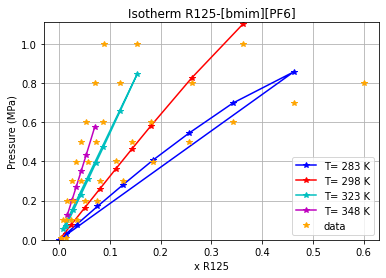

In [5]:
# for i in range(len(P)):
#     P[i] = P[i]*1e6
P1= np.zeros((len(P)))

for i in range(len(P)):
    P1[i] = P[i]/1e6

plt.plot(R125_x[0:9],P1[0:9],"b*-",label="T= 283 K")  
plt.plot(R125_x[9:18],P1[9:18],"r*-",label="T= 298 K") 
plt.plot(R125_x[18:27],P1[18:27],"c*-",label="T= 323 K") 
plt.plot(R125_x[27:33],P1[27:33],"m*-",label="T= 348 K")
plt.plot(data["x_R125"],data["pressure"]/1e6,"*",color='orange',label="data")  
plt.title('Isotherm R125-[bmim][PF6]')
plt.ylabel('Pressure (MPa)')
plt.xlabel('x R125')
plt.grid(True)
plt.ylim(0,1.110000)
plt.legend()
plt.show()

In [6]:
m.fs.F101.report()


Unit : fs.F101                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value       : Fixed : Bounds
          Heat Duty :      368.61 : False : (None, None)
    Pressure Change : -2.6967e+05 : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                              Inlet    Vapor Outlet  Liquid Outlet
    flow_mol                   1.0000     0.087719       0.91228  
    mole_frac_comp bmimPF6    0.83200   1.0000e-08       0.91200  
    mole_frac_comp R125       0.16800       1.0000      0.088000  
    temperature                348.20       348.20        348.20  
    pressure               9.9960e+05   7.2993e+05    7.2993e+05  


In [7]:
print(P1)

[0.02968795 0.0775732  0.17020731 0.28174553 0.40742362 0.5432903
 0.69764788 0.8570563  0.         0.00980267 0.07513328 0.16318072
 0.26006305 0.36076949 0.46317106 0.57993169 0.82631287 1.1041387
 0.06975056 0.15068939 0.22707817 0.30852932 0.39157381 0.47362923
 0.65725207 0.84846705 0.05604329 0.12875254 0.20221027 0.26740768
 0.34988849 0.43306783 0.57698054 0.72992938]
